In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datasets import load_dataset
from einops import rearrange
from utils import get_separated_activations, flattened_idx_to_layer_head
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import requests

/data/wtl/anaconda3/envs/iti/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
head_wise_activations = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_100_head_wise.pkl', 'rb'))
labels = np.load('/data/jxf/activations/llama_7B_tqa_mc2_all_labels.npy')
activation_categories = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_categories.pkl', 'rb'))
tokens = pkl.load(open('/data/jxf/activations/llama_7B_tqa_mc2_all_tokens.pkl', 'rb'))
num_heads = 32
head_wise_activations = rearrange(head_wise_activations, 'b l (h d) -> b l h d', h = num_heads)

In [3]:

def get_separated_activations(labels, head_wise_activations, categories): 

    # separate activations by question
    url = "https://huggingface.co/api/datasets/truthful_qa/parquet/multiple_choice/validation/0.parquet"
    dataset = load_dataset('parquet', data_files=url)['train']
    actual_labels = []
    for i in range(len(dataset)):
        actual_labels.append(dataset[i]['mc2_targets']['labels'])
    

    idxs_to_split_at = np.cumsum([len(x) for x in actual_labels])        

    labels = list(labels)
    categories = list(categories)
    separated_labels = []
    separated_categories = []
    for i in range(len(idxs_to_split_at)):
        if i == 0:
            separated_labels.append(labels[:idxs_to_split_at[i]])
            separated_categories.append(categories[:idxs_to_split_at[i]])
        else:
            separated_labels.append(labels[idxs_to_split_at[i-1]:idxs_to_split_at[i]])
            separated_categories.append(categories[idxs_to_split_at[i-1]:idxs_to_split_at[i]])

    separated_head_wise_activations = np.split(head_wise_activations, idxs_to_split_at)

    return separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at

separated_head_wise_activations, separated_labels, separated_categories, idxs_to_split_at = get_separated_activations(labels, head_wise_activations, activation_categories)

Found cached dataset parquet (/data/wtl/hf_cache/parquet/default-45ee6c5a774c2d3f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 1/1 [00:00<00:00, 494.49it/s]


In [4]:
print(len(separated_head_wise_activations)) # fix -> 817
print(separated_head_wise_activations[0].shape)
print(separated_labels[:5])
print(separated_categories[:5])

818
(4, 32, 32, 128)
[[1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0]]
[['Distraction', 'Distraction', 'Distraction', 'Distraction'], ['Economics', 'Economics', 'Economics', 'Economics', 'Economics', 'Economics', 'Economics', 'Economics'], ['Psychology', 'Psychology', 'Psychology', 'Psychology', 'Psychology', 'Psychology'], ['Weather', 'Weather', 'Weather', 'Weather', 'Weather', 'Weather'], ['Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies', 'Conspiracies']]


In [5]:
head_wise_activation_directions = np.array([a[np.array(l) == 1].mean(axis=0) - a[np.array(l) == 0].mean(axis=0) for a, l in zip(separated_head_wise_activations, separated_labels)])

In [6]:
head_wise_activation_directions.shape
question_categories = [_[0] for _ in separated_categories]
categories = list(set(question_categories))
print(f'幻觉类型数量: {len(categories)}')

幻觉类型数量: 38


# 聚类可视化观察

/tmp/ipykernel_52739/1201632404.py:54: UserWarning: The palette list has more values (15) than needed (13), which may not be intended.
  scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Category', data=df_selected_tsne, legend="full", palette=sns.color_palette("hsv", n_colors=num_clusters), alpha=0.7)


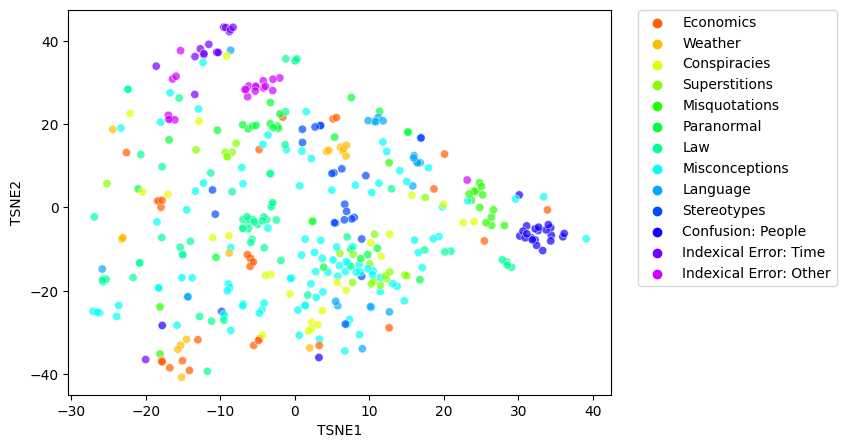

In [7]:
layer = 11
head = 6

num_questions = len(head_wise_activation_directions)
selected_categories = question_categories
selected_data = head_wise_activation_directions[:, layer, head, :]

# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

# 使用K-means进行聚类，分成几个大类
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(selected_data)

df = pd.DataFrame(selected_data)
df['Category'] = selected_categories
df['Cluster'] = clusters

# 使用t-SNE对所有样本进行降维
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(selected_data) # 除去Category和Cluster列
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = df['Category']


# 计算每个小类在每个大类中的占比评分
category_cluster_proportion = df.groupby(['Category', 'Cluster']).size().groupby(level=0).apply(lambda x: x / float(x.sum()))

# 设置样本数阈值 k
k = 15

# 对于每个大类，找出评分最高且样本数大于等于k的小类
top_categories_per_cluster = []
for cluster in range(num_clusters):
    # 获取当前大类中的小类评分
    cluster_scores = category_cluster_proportion[:, cluster]
    
    # 按评分排序
    sorted_scores = cluster_scores.sort_values(ascending=False)
    
    # 检查每个小类的样本数，选择满足条件的最高评分小类
    for category in sorted_scores.index:
        if df[(df['Category'] == category)].shape[0] > k:
            top_categories_per_cluster.append(category)
            break

# 仅在可视化中展示筛选出的小类
df_selected_tsne = df_tsne[df_tsne['Category'].isin(top_categories_per_cluster)]

# 可视化每个大类中评分最高的小类
plt.figure(figsize=(7, 5))
# scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Category',style='Cluster', data=df_selected, legend="full", palette=sns.color_palette("hsv", n_colors=len(highest_score_categories)), alpha=0.7)
scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Category', data=df_selected_tsne, legend="full", palette=sns.color_palette("hsv", n_colors=num_clusters), alpha=0.7)
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

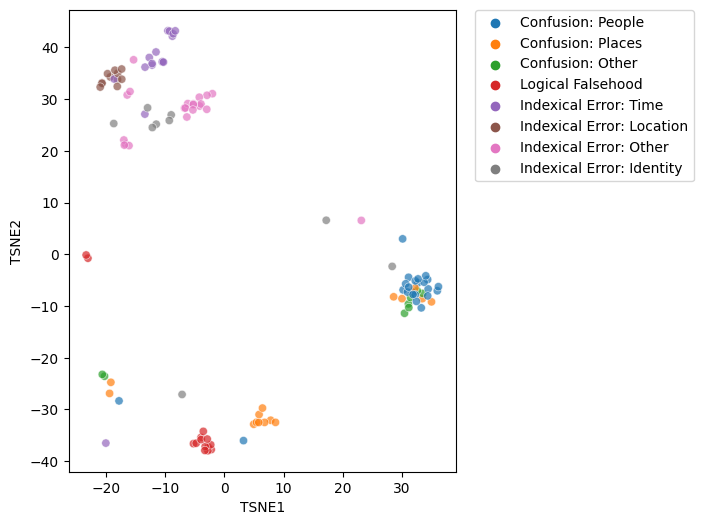

In [8]:
selected = ['Confusion: People',
            'Confusion: Places',
            'Confusion: Other',
            'Logical Falsehood',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            'Indexical Error: Identity',
            ]

layer = 11
head = 6

selected_data = head_wise_activation_directions[:, layer, head, :]
# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(selected_data)
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = question_categories

df_tsne_select = df_tsne[df_tsne['Category'].isin(selected)]

plt.figure(figsize=(5, 6))
scatter = sns.scatterplot(x='TSNE1', 
                          y='TSNE2', 
                          hue='Category', 
                          hue_order=selected,
                          data=df_tsne_select, 
                          legend="full", 
                          alpha=0.7
                          )
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

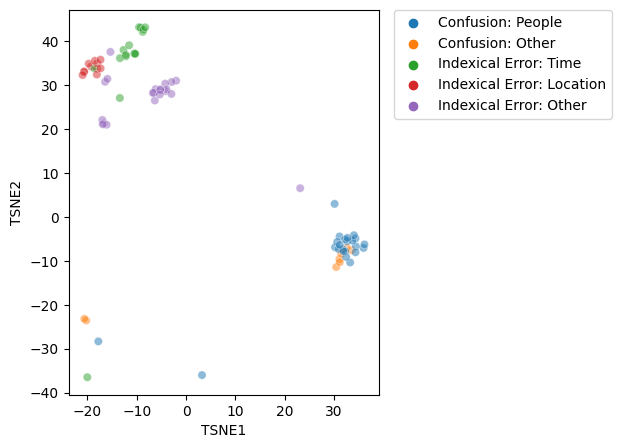

In [9]:
selected = ['Confusion: People',
            'Confusion: Other',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            ]

layer = 11
head = 6

selected_data = head_wise_activation_directions[:, layer, head, :]
# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=1).reshape(-1, 1)

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(selected_data)
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Category'] = question_categories

df_tsne_select = df_tsne[df_tsne['Category'].isin(selected)]

plt.figure(figsize=(4, 5))
scatter = sns.scatterplot(x='TSNE1', 
                          y='TSNE2', 
                          hue='Category', 
                          hue_order=selected,
                          data=df_tsne_select, 
                          legend="full",
                          # s=100,
                          # palette=sns.color_palette("hsv", n_colors=len(selected)),
                          alpha=0.5
                          )
# 将图例放在图表外部
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

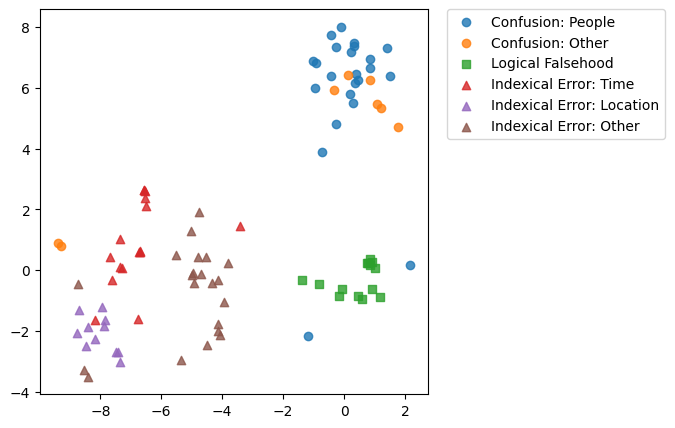

In [11]:
layer = 11
head = 6
subclass_names = ['Confusion: People',
            'Confusion: Other',
            'Logical Falsehood',
            'Indexical Error: Time',
            'Indexical Error: Location',
            'Indexical Error: Other',
            ]

subclass2class = {'Confusion: People':'Confusion',
                'Confusion: Other':'Confusion', 
                'Logical Falsehood':'Logical Falsehood', 
                'Indexical Error: Time':'Indexical Error',
                'Indexical Error: Location':'Indexical Error',
                'Indexical Error: Other':'Indexical Error'
                }


selected_idx = [i for i, sel in enumerate(question_categories) if sel in subclass_names]
selected_data = head_wise_activation_directions[selected_idx, layer, head, :]
selected_subclass = [question_categories[i] for i in selected_idx]
selected_class = [subclass2class[_] for _ in selected_subclass]

# Assign colors and markers
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markers = ['o', 'o', 's', '^', '^', '^']


# 求范数，获取方向向量
selected_data = selected_data / np.linalg.norm(selected_data, axis=-1).reshape(-1, 1)

tsne = TSNE(n_components=2, random_state=0)
df_tsne = tsne.fit_transform(selected_data)
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['class'] = selected_class
df_tsne['subclass'] = selected_subclass


plt.figure(figsize=(5, 5))
for i, subclass in enumerate(subclass_names):
    df_subclass = df_tsne[df_tsne['subclass'] == subclass]
    plt.scatter(df_subclass['TSNE1'], df_subclass['TSNE2'], c=colors[i], marker=markers[i], label=f"{subclass}", alpha=0.8)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## 保存directions

In [88]:
import os
os.makedirs('/data/wtl/honest_llm/directions', exist_ok=True)
np.save('/data/wtl/honest_llm/directions/head_wise_activation_directions.npy', head_wise_activation_directions)